## Homework 08: Classification

**Due:** Midnight on March 23 (with a 2-hour grace period)  


### Overview

In this final homework before starting our course project, we will introduce the essential machine learning paradigm of **classification**. We will work with a well-known Kaggle dataset—the Pima Indians Diabetes dataset—to determine whether an individual has diabetes (1) or not (0). This is a binary classification task.

As we’ve discussed in this week’s lessons, the classification workflow is similar to what we’ve done for regression, with a few key differences:
- Instead of `RepeatedKFold` we use `RepeatedStratifiedKFold` (read the docs to understand the difference)
- We use classification metrics (e.g., accuracy, precision, recall, F1-score) instead of regression metrics--for simplicity we'll just use accuracy in this homework. 

For this assignment, you’ll build two models and measure their performance using the accuracy metric. 
1. A **logistic regression** classifier as a baseline.
2. One of the **ensemble** classifiers of your choice.

Because we’ve already covered much of the workflow in our regression assignments, this homework is intentionally concise and less prescriptive.

### Grading

There are 5 graded problems, each worth 5 points, for a total of 25 points.

In [2]:
# Useful imports

import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import zipfile
import time

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold,GridSearchCV
from sklearn.ensemble        import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score
from sklearn.preprocessing   import StandardScaler
from tqdm                    import tqdm

from collections import Counter

# globals

random_state = 42


### Problem One:  Load, Explore, and Preprocess the Kaggle Pima Indians Diabetes Dataset 

In the follow cell(s), 
- Download the dataset from Kaggle
- Perform some simple EDA using `.head()`, `.info()` and `.hist()`
    - When using a classification dataset, **always** look to see whether the target is balanced (approximately equal numbers of classes) or not. 
- Create the feature set `X` and the target set `y` (using `Outcome` as the target)
- Scale `X` using `StandardScalar` (since the classification models often prefer this)
- Split the dataset into 80% training and 20% testing sets
- Verify that the graded answer is correct

In [3]:
# Download the Pima Indians Diabetes dataset from Kaggle
dataset_name = "uciml/pima-indians-diabetes-database"
output_dir = "datasets/pima_indians_diabetes"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Use kaggle API to download the dataset
!kaggle datasets download -d {dataset_name} -p {output_dir} --unzip

# Verify the downloaded files
print(f"Files in {output_dir}:")
print(os.listdir(output_dir))

Dataset URL: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
License(s): CC0-1.0
  0%|                                               | 0.00/8.91k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 8.91k/8.91k [00:00<00:00, 14.0MB/s]
Files in datasets/pima_indians_diabetes:
['diabetes.csv']


In [4]:
# load the dataframe
diabetes = pd.read_csv(f"{output_dir}/diabetes.csv")
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# Your code here
diabetes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

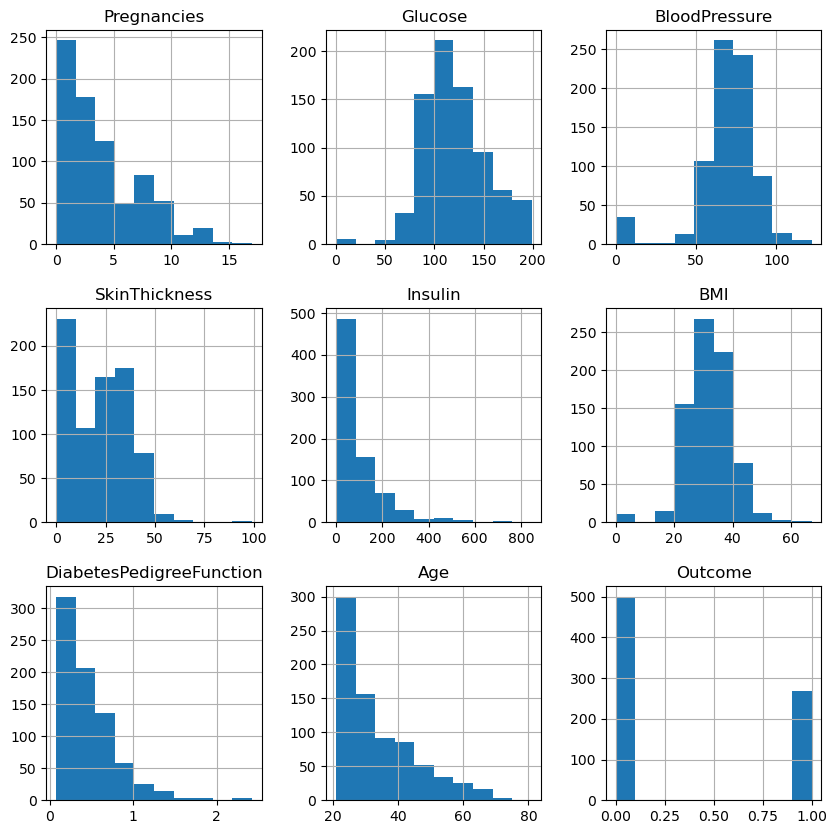

In [7]:
diabetes.hist(figsize=(10,10))

In [149]:
X.query("BMI == 0").shape[0]

11

In [8]:
X = diabetes.drop(columns="Outcome")
y = diabetes["Outcome"]
print(X.shape, y.shape)

(768, 8) (768,)


In [9]:

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [10]:
# standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Problem 1 Graded Answer

In [11]:
# Nothing to do, but you might want to check and make sure this is correct

a1 = (X_train.shape,X_test.shape)                          

print(f'a1 = {a1}')              # Do not change this line, and DO NOT print anything else in this cell

a1 = ((614, 8), (154, 8))


## Interlude: Wrapper Functions for Running Classification Models

The following cells are adapted from the Week 7 homework in order to use accuracy as the error metric. You can easily modify these
if you wish to consider other metrics.  


**Note:** `sweep_parameter` sets `X_train` etc. to default values using the global values for `X_train` etc. you created in problem 1.  Should work fine as is, but you can always just ignore the defaults and assign the parameters explicitly. 


In [12]:
def run_model(model, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, **model_params):

    # Remove extra key used to store error metric, if it was added to the parameter dictionary
    
    if 'accuracy_found' in model_params:
        model_params = model_params.copy()
        model_params.pop('accuracy_found', None)  
        
    # Instantiate the model if a class is provided
    if isinstance(model, type):
        model = model(**model_params)
    else:                                    
        model.set_params(**model_params)    

    # Use RepeatedStratifiedKFold for classification to preserve class distribution
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    
    # Perform 5-fold cross-validation using accuracy as the scoring metric
    cv_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=n_jobs)
    
    mean_cv_accuracy = np.mean(cv_scores)
    std_cv_accuracy  = np.std(cv_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training and testing accuracy
    train_preds    = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_preds)
    test_preds     = model.predict(X_test)
    test_accuracy  = accuracy_score(y_test, test_preds)
    
    return mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy


In [13]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,                 # The defaults use global parameters, you can override this by simply giving the arguments explicitly
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10
                   ):

    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_accuracies, std_cvs, train_accuracies, test_accuracies = [], [], [], []
    no_improve_count = 0
    best_accuracy = -np.inf  # since higher accuracy is better
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove accuracy_found if present, just in case
        P_temp.pop('accuracy_found', None)
        
        # run_model should return: mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy
        mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_accuracies.append(mean_cv_accuracy)
        std_cvs.append(std_cv_accuracy)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        # Early-stopping logic: maximize accuracy
        if mean_cv_accuracy > best_accuracy + delta:
            best_accuracy = mean_cv_accuracy
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break
    
    # Identify best parameter
    max_cv_accuracy = max(cv_accuracies)
    max_index = cv_accuracies.index(max_cv_accuracy)
    best_param = parameter_list[max_index]
    Parameters[param] = best_param
    Parameters['accuracy_found'] = max_cv_accuracy
    
    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        
        # Use only as many parameter values as computed
        partial_param_list = parameter_list[:len(cv_accuracies)]
        
        # Check if our parameter list is Boolean for proper labeling
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        # ----- First plot: Accuracy -----
        ax1.set_title(f"Accuracy vs {param}")
        
        ax1.plot(x_vals,
                 cv_accuracies,
                 marker='.', label="CV Accuracy", color='blue')
        ax1.plot(x_vals,
                 train_accuracies,
                 marker='.', label="Train Accuracy", color='green')
        ax1.plot(x_vals,
                 test_accuracies,
                 linestyle='--', label="Test Accuracy", color='orange')
        ax1.scatter([x_vals[max_index]],
                    [max_cv_accuracy],
                    marker='x', label="Best CV Accuracy", color='red')
        
        ax1.set_ylabel("Accuracy")
        ax1.legend()
        ax1.grid()
        
        # ----- Second plot: CV Standard Deviation -----
        ax2.set_title(f"CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label="CV Accuracy Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha=0.5)
        
        # If using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))
    
    return Parameters


## Problem Two: Classification using Logistic Regression (Baseline)  

For this problem,
- Read the docs for `LogisticRegression`
- Run the model with `class_weight = 'balanced'` and `max_iter=1000` using `run_model` or just your own code. 
- Answer the graded questions

In [14]:
# Your code; add as many cells as you need
log_params = {
    'solver': 'liblinear',
    'penalty': 'l2',
    'C': 1.0,
    'max_iter': 1000,
    'class_weight': 'balanced',
    'accuracy_found': float('-inf')
}

Sweeping C:  89%|████████▉ | 8/9 [00:01<00:00,  4.74it/s]


Early stopping: No improvement after 5 iterations.


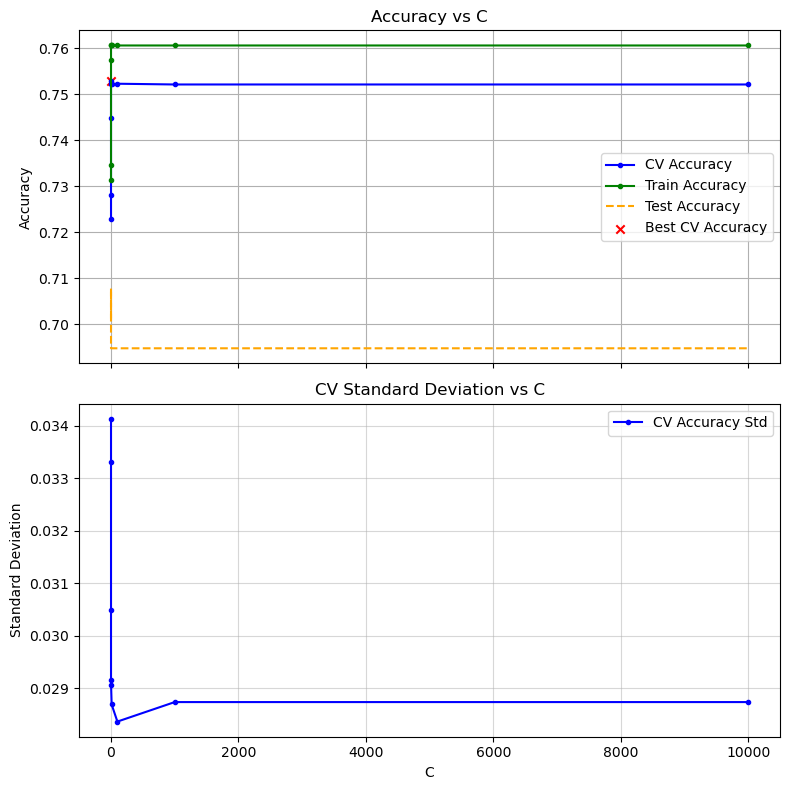

Execution Time: 00:00:01
{'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1, 'max_iter': 1000, 'class_weight': 'balanced', 'accuracy_found': 0.7527642276422765}


In [15]:
log_params = sweep_parameter(
    model=LogisticRegression,
    Parameters=log_params,
    param='C',
    parameter_list= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    n_iter_no_change=5
)

print(log_params)

Sweeping penalty: 100%|██████████| 2/2 [00:00<00:00, 16.20it/s]


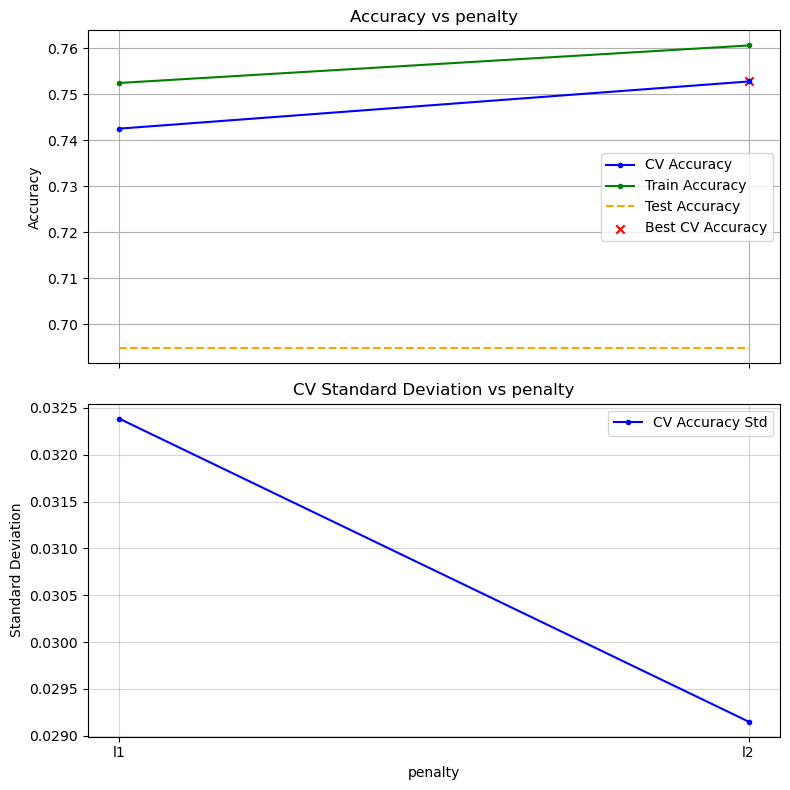

Execution Time: 00:00:00
{'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1, 'max_iter': 1000, 'class_weight': 'balanced', 'accuracy_found': 0.7527642276422765}


In [16]:
log_params = sweep_parameter(
    model=LogisticRegression,
    Parameters=log_params,
    param='penalty',
    parameter_list=['l1', 'l2'],
    n_iter_no_change=5
)

print(log_params)

In [17]:
log_params

{'solver': 'liblinear',
 'penalty': 'l2',
 'C': 0.1,
 'max_iter': 1000,
 'class_weight': 'balanced',
 'accuracy_found': 0.7527642276422765}

Sweeping solver: 100%|██████████| 5/5 [00:00<00:00, 35.04it/s]


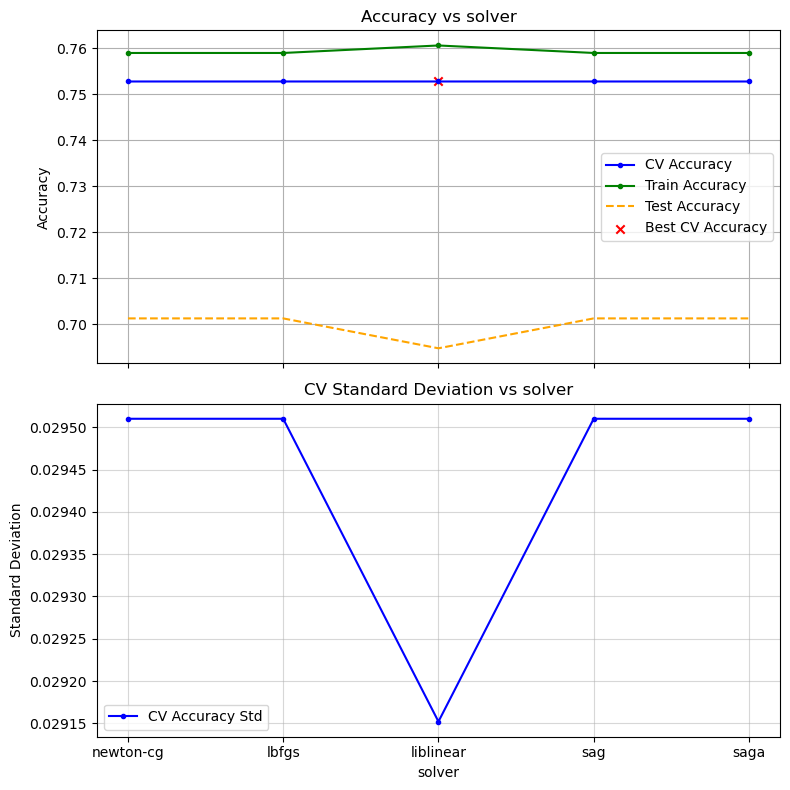

Execution Time: 00:00:00
{'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1, 'max_iter': 1000, 'class_weight': 'balanced', 'accuracy_found': 0.7527642276422765}


In [18]:
log_params = sweep_parameter(
    model=LogisticRegression,
    Parameters=log_params,
    param='solver',
    parameter_list=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    n_iter_no_change=5
)

print(log_params)

In [19]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
# Record start time
start_time = time.time()

# Define parameter grid as a list of dictionaries to avoid incompatible combinations
param_grid_refined = [
    {
        'C': [0.05, 0.075, 0.1, 0.125, 0.15],
        'penalty': ['l1'],
        'solver': ['saga']
    },
    {
        'C': [0.05, 0.075, 0.1, 0.125, 0.15],
        'penalty': ['l2'],
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
    }
]

# Initialize the LogisticRegression model
log_model = LogisticRegression(random_state=42, max_iter=1000)

# Set up cross-validation: RepeatedKFold with 3 splits repeated 3 times
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=log_model,
    param_grid=param_grid_refined,
    scoring='accuracy',  # Using accuracy as the evaluation metric
    cv=cv,
    n_jobs=-1,
    verbose=1  # Prints progress during the search
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Create a DataFrame of the results
results_df = pd.DataFrame(grid_search.cv_results_)

# Sort results by mean test accuracy in descending order
sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)

# Display the top 10 parameter combinations by accuracy
print("\nTop 10 Parameter Combinations by Accuracy:")
print(sorted_results[['param_C', 'param_penalty', 'param_solver', 'mean_test_score']].head(10))

# Get the best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(f"\nBest Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# Print the execution time
execution_time = time.time() - start_time
print(f"\nExecution Time: {execution_time:.2f}s")

Fitting 9 folds for each of 25 candidates, totalling 225 fits

Top 10 Parameter Combinations by Accuracy:
    param_C param_penalty param_solver  mean_test_score
2     0.100            l1         saga         0.765471
1     0.075            l1         saga         0.764390
3     0.125            l1         saga         0.763845
24    0.150            l2         saga         0.761130
23    0.150            l2          sag         0.761130
22    0.150            l2        lbfgs         0.761130
21    0.150            l2    newton-cg         0.761130
4     0.150            l1         saga         0.760588
20    0.125            l2         saga         0.760585
19    0.125            l2          sag         0.760585

Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Best Accuracy: 0.7655

Execution Time: 0.08s


In [20]:
best_accuracy

0.7654710664753707

### Problem 2.A Graded Answer

Provide the mean CV accuracy score of your best model in the next cell. 

In [21]:
# Insert the mean CV accuracy

a2a = best_accuracy                              # Just to get it to run without errors, put your answer here                       

print(f'a2a = {a2a:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a2a = 0.7655


### Problem 2.B Graded Answer

Provide the test accuracy of your best model in the next cell. 

In [22]:
p_2 = run_model(LogisticRegression, X_train, y_train, X_test, y_test, **best_params)
print(p_2)

(0.7635145941623349, 0.03186450279059534, 0.7654723127035831, 0.7662337662337663)


In [23]:
# Insert the test accuracy

a2b = p_2[3]                               # Just to get it to run without errors, put your answer here                          

print(f'a2b = {a2b:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a2b = 0.7662


## Problem Three: Classification using Ensemble Methods  

For this problem,
- Choose one of the ensemble methods for classification (see the first code cell above)
- Read about the hyperparameters for the model in the `sklearn` docs
- Tune the model for best performance using the wrapper functions and/or grid search as needed
- Answer the graded questions


In [24]:
# Your code here
bagging_params = {
    'n_estimators': 10,
    'max_samples': 1.0,
    'max_features': 1.0,
    'bootstrap': False,
    'bootstrap_features': False,
    'oob_score': False,
    'accuracy_found': float('-inf')
}

Sweeping n_estimators: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


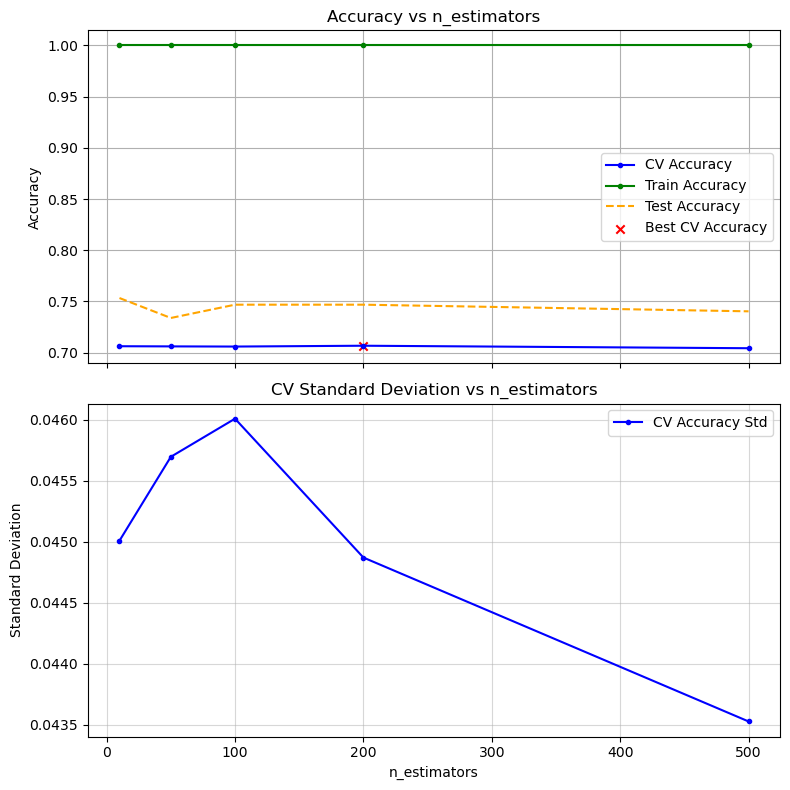

Execution Time: 00:00:08
{'n_estimators': 200, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap': False, 'bootstrap_features': False, 'oob_score': False, 'accuracy_found': 0.7066506730641077}


In [25]:
bagging_params = sweep_parameter(
    model=BaggingClassifier,
    Parameters=bagging_params,
    param='n_estimators',
    parameter_list=[10, 50, 100, 200, 500],
    n_iter_no_change=5
)
print(bagging_params)

Sweeping max_samples: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


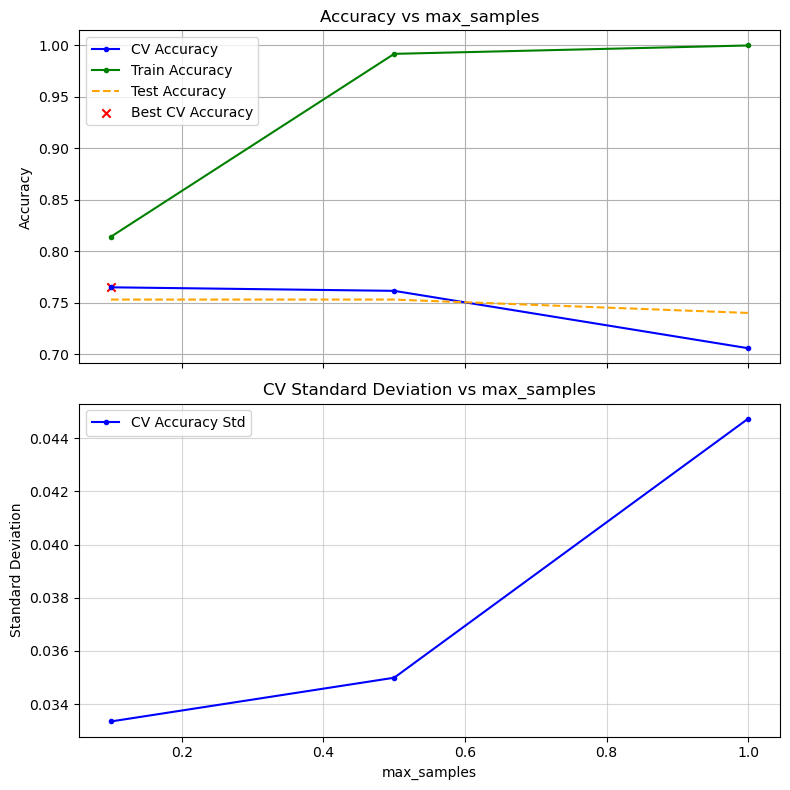

Execution Time: 00:00:03
{'n_estimators': 200, 'max_samples': 0.1, 'max_features': 1.0, 'bootstrap': False, 'bootstrap_features': False, 'oob_score': False, 'accuracy_found': 0.765152605624417}


In [26]:
bagging_params = sweep_parameter(
    model=BaggingClassifier,
    Parameters=bagging_params,
    param='max_samples',
    parameter_list=[0.1, 0.5, 1.0],
    n_iter_no_change=5
)
print(bagging_params)

Sweeping max_features: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


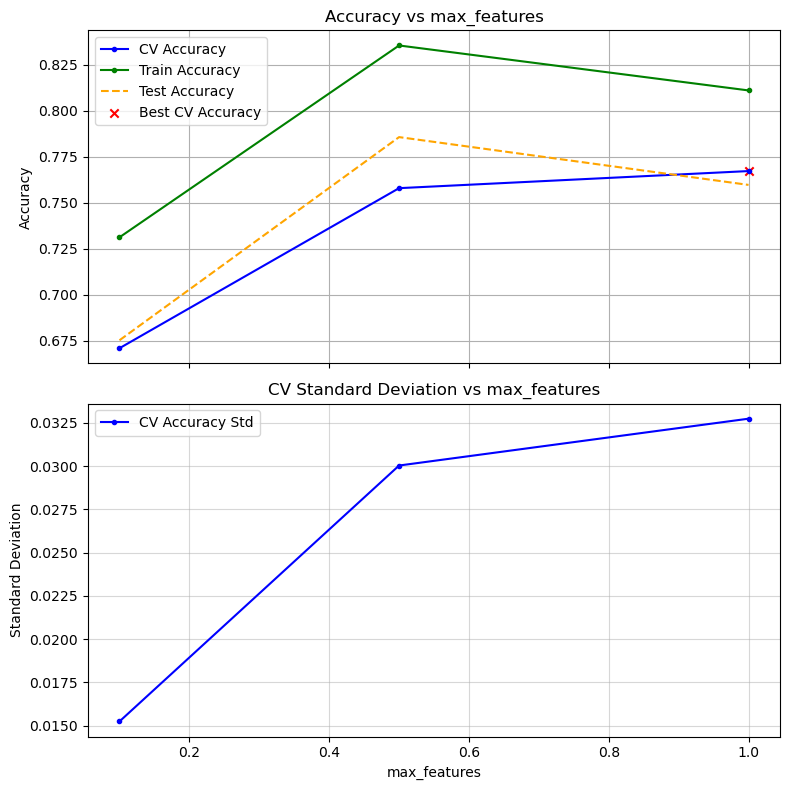

Execution Time: 00:00:02
{'n_estimators': 200, 'max_samples': 0.1, 'max_features': 1.0, 'bootstrap': False, 'bootstrap_features': False, 'oob_score': False, 'accuracy_found': 0.7672610955617752}


In [27]:
bagging_params = sweep_parameter(
    model=BaggingClassifier,
    Parameters=bagging_params,
    param='max_features',
    parameter_list=[0.1, 0.5, 1.0],
    n_iter_no_change=5
)
print(bagging_params)

Sweeping bootstrap: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


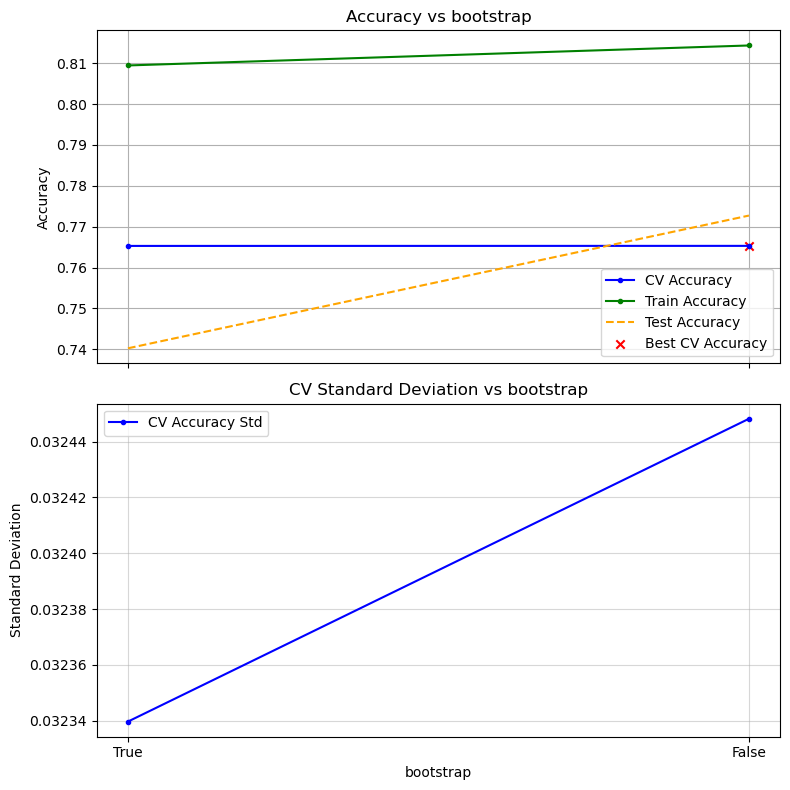

Execution Time: 00:00:01
{'n_estimators': 200, 'max_samples': 0.1, 'max_features': 1.0, 'bootstrap': False, 'bootstrap_features': False, 'oob_score': False, 'accuracy_found': 0.76531387445022}


In [28]:
bagging_params = sweep_parameter(
    model=BaggingClassifier,
    Parameters=bagging_params,
    param='bootstrap',
    parameter_list=[True, False],
    n_iter_no_change=5
)
print(bagging_params)

Sweeping bootstrap_features: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


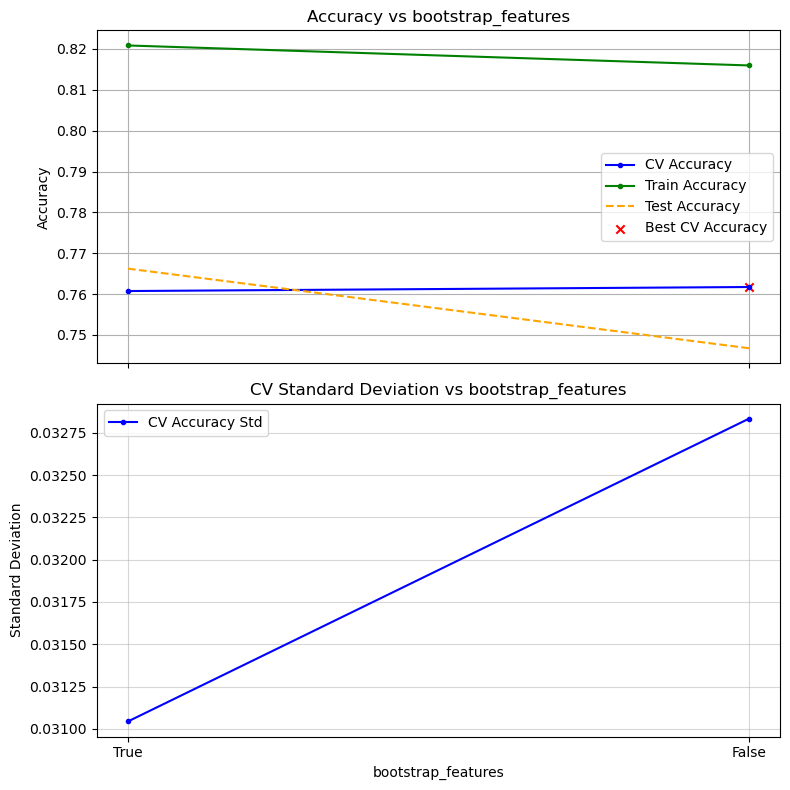

Execution Time: 00:00:01
{'n_estimators': 200, 'max_samples': 0.1, 'max_features': 1.0, 'bootstrap': False, 'bootstrap_features': False, 'oob_score': False, 'accuracy_found': 0.7617326402772224}


In [29]:
bagging_params = sweep_parameter(
    model=BaggingClassifier,
    Parameters=bagging_params,
    param='bootstrap_features',
    parameter_list=[True, False],
    n_iter_no_change=5
)
print(bagging_params)

In [30]:
oob_bagging = bagging_params.copy()
oob_bagging['bootstrap'] = True
print(oob_bagging)

{'n_estimators': 200, 'max_samples': 0.1, 'max_features': 1.0, 'bootstrap': True, 'bootstrap_features': False, 'oob_score': False, 'accuracy_found': 0.7617326402772224}


Sweeping oob_score: 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


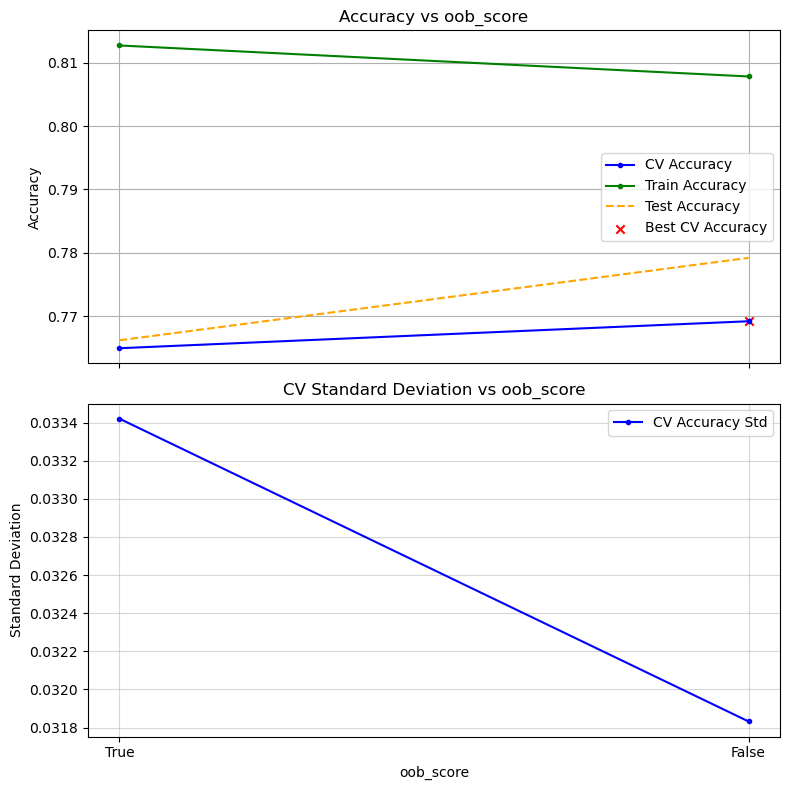

Execution Time: 00:00:01
{'n_estimators': 200, 'max_samples': 0.1, 'max_features': 1.0, 'bootstrap': True, 'bootstrap_features': False, 'oob_score': False, 'accuracy_found': 0.7692296414767426}


In [31]:
oob_bagging = sweep_parameter(
    model=BaggingClassifier,
    Parameters=oob_bagging,
    param='oob_score',
    parameter_list=[True, False],
    n_iter_no_change=5
)
print(oob_bagging)

In [141]:
rf_default_params = {
    'criterion': 'gini',
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'min_weight_fraction_leaf': 0.0,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'bootstrap': True,
    'oob_score': False,
    'warm_start': False,
    'class_weight': 'balanced',
    'ccp_alpha': 0.01,
    'max_samples': None,
    'monotonic_cst': None,
    'accuracy_found': float('-inf'),
    'random_state': random_state
}

print(rf_default_params)

{'criterion': 'gini', 'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'bootstrap': True, 'oob_score': False, 'warm_start': False, 'class_weight': 'balanced', 'ccp_alpha': 0.01, 'max_samples': None, 'monotonic_cst': None, 'accuracy_found': -inf, 'random_state': 42}


In [142]:
default_run = run_model(RandomForestClassifier, X_train, y_train, X_test, y_test, **rf_default_params)
print(default_run)

(0.7534159669465548, 0.038166619831275284, 0.8061889250814332, 0.7532467532467533)


Sweeping n_estimators: 100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


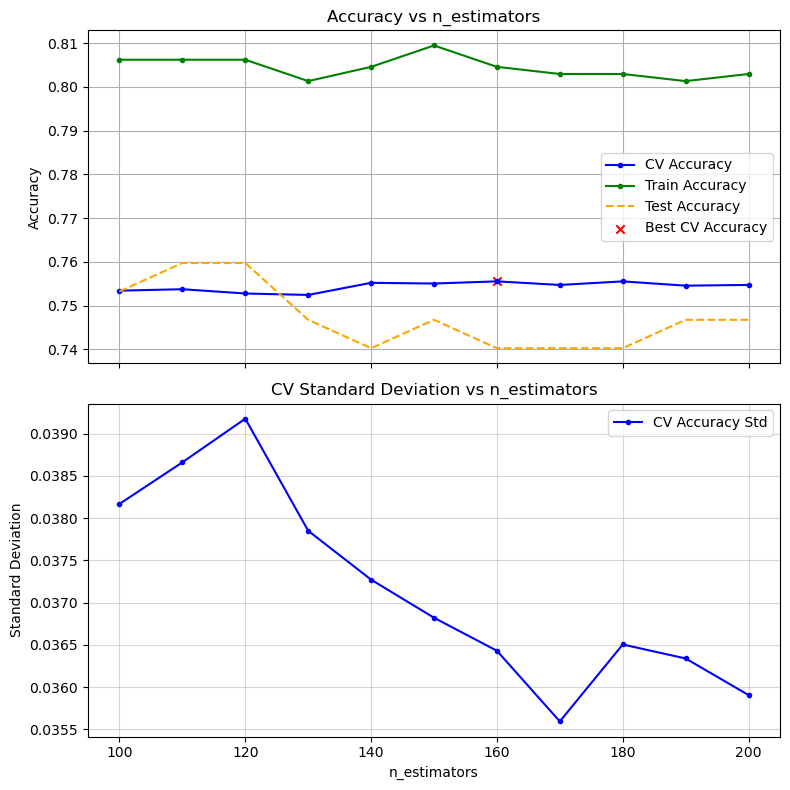

Execution Time: 00:00:06
{'criterion': 'gini', 'n_estimators': 160, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'bootstrap': True, 'oob_score': False, 'warm_start': False, 'class_weight': 'balanced', 'ccp_alpha': 0.01, 'max_samples': None, 'monotonic_cst': None, 'accuracy_found': 0.7555404504864721, 'random_state': 42}


In [143]:
rf_default_params = sweep_parameter(
    model=RandomForestClassifier,
    Parameters=rf_default_params,
    param='n_estimators',
    parameter_list=[100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
)
print(rf_default_params)

Sweeping max_depth: 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


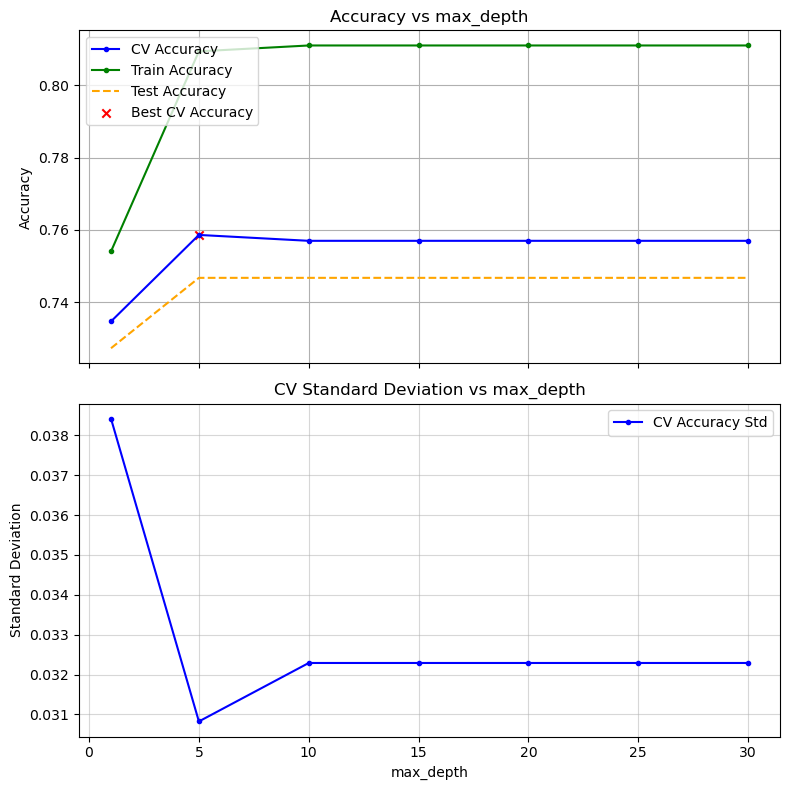

Execution Time: 00:00:03
{'n_estimators': 160, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'log2', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'bootstrap': True, 'oob_score': False, 'warm_start': False, 'class_weight': 'balanced', 'ccp_alpha': 0.0005, 'max_samples': None, 'monotonic_cst': None, 'accuracy_found': 0.7586325469812075, 'random_state': 42}


In [127]:
rf_default_params = sweep_parameter(
    model=RandomForestClassifier,
    Parameters=rf_default_params,
    param='max_depth',
    parameter_list=[1, 5, 10, 15, 20, 25, 30] 
)
print(rf_default_params)

Sweeping min_samples_split: 100%|██████████| 14/14 [00:07<00:00,  1.95it/s]


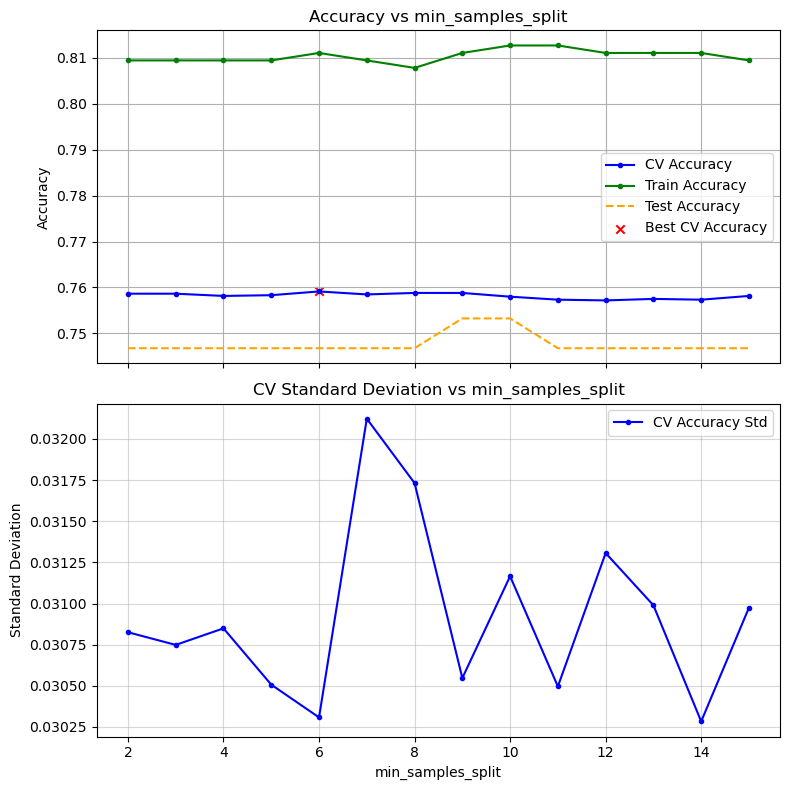

Execution Time: 00:00:07
{'n_estimators': 160, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'log2', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'bootstrap': True, 'oob_score': False, 'warm_start': False, 'class_weight': 'balanced', 'ccp_alpha': 0.0005, 'max_samples': None, 'monotonic_cst': None, 'accuracy_found': 0.7591216846594697, 'random_state': 42}


In [130]:
rf_default_params = sweep_parameter(
    model=RandomForestClassifier,
    Parameters=rf_default_params,
    param='min_samples_split',
    parameter_list=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
)
print(rf_default_params)

Sweeping min_samples_leaf: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


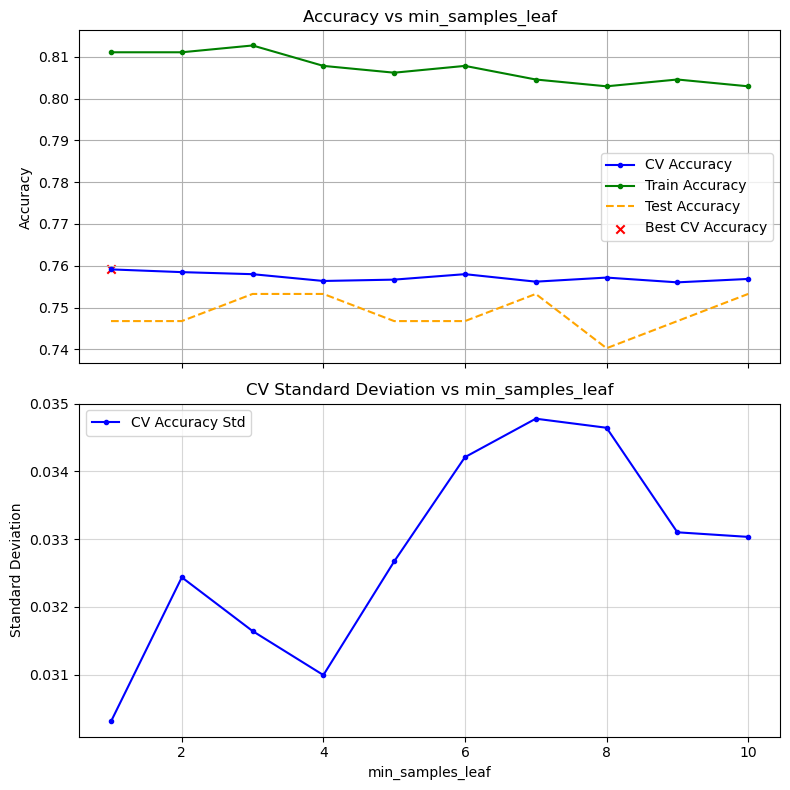

Execution Time: 00:00:05
{'n_estimators': 160, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'log2', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'bootstrap': True, 'oob_score': False, 'warm_start': False, 'class_weight': 'balanced', 'ccp_alpha': 0.0005, 'max_samples': None, 'monotonic_cst': None, 'accuracy_found': 0.7591216846594697, 'random_state': 42}


In [131]:
rf_default_params = sweep_parameter(
    model=RandomForestClassifier,
    Parameters=rf_default_params,
    param='min_samples_leaf',
    parameter_list=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
)
print(rf_default_params)

Sweeping min_weight_fraction_leaf: 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


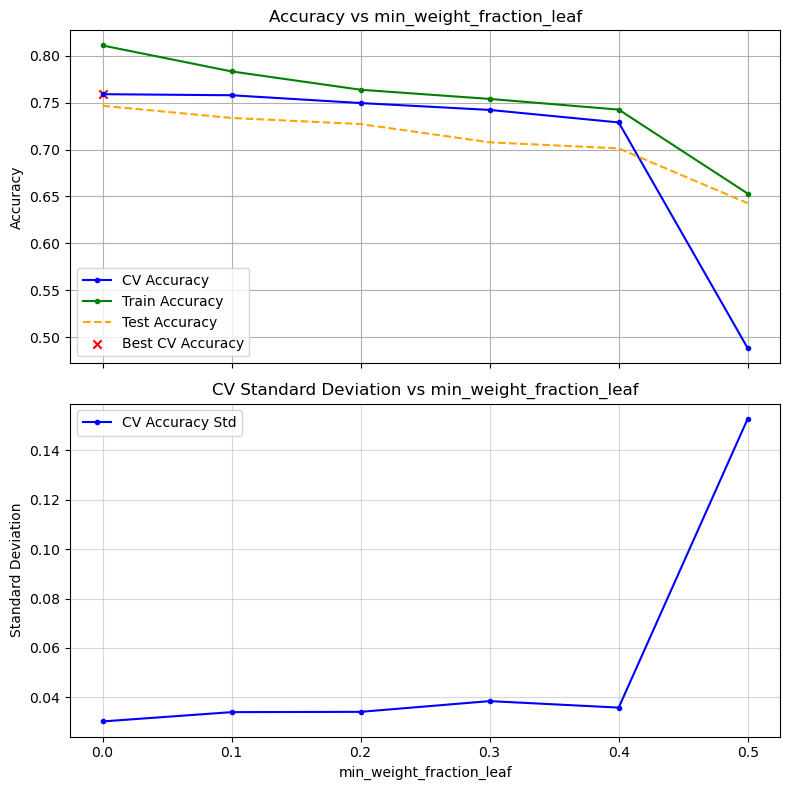

Execution Time: 00:00:02
{'n_estimators': 160, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'log2', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'bootstrap': True, 'oob_score': False, 'warm_start': False, 'class_weight': 'balanced', 'ccp_alpha': 0.0005, 'max_samples': None, 'monotonic_cst': None, 'accuracy_found': 0.7591216846594697, 'random_state': 42}


In [132]:
rf_default_params = sweep_parameter(
    model=RandomForestClassifier,
    Parameters=rf_default_params,
    param='min_weight_fraction_leaf',
    parameter_list=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
)
print(rf_default_params)

Sweeping max_features: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


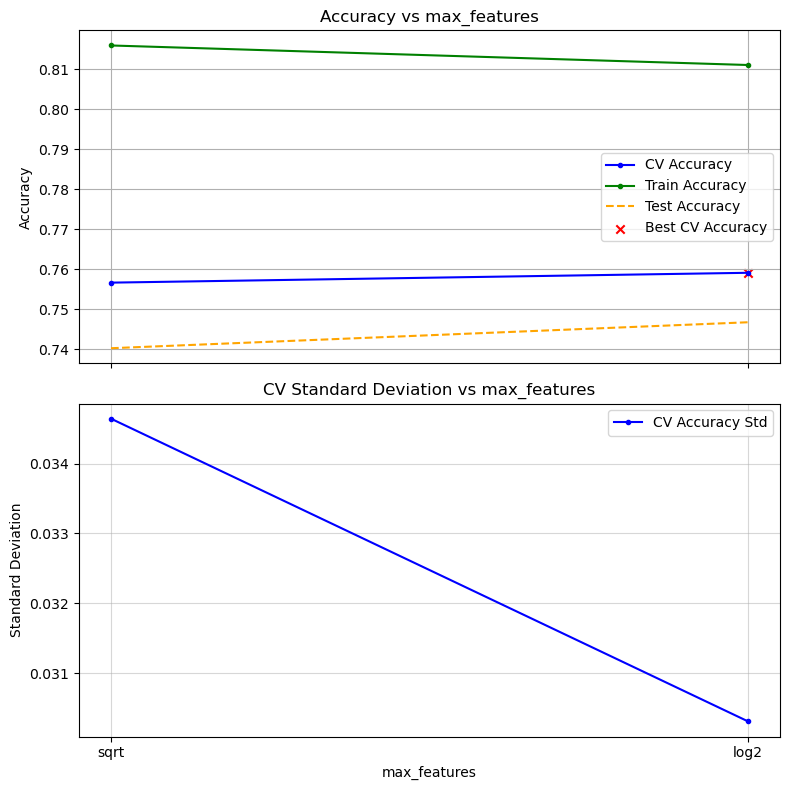

Execution Time: 00:00:01
{'n_estimators': 160, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'log2', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'bootstrap': True, 'oob_score': False, 'warm_start': False, 'class_weight': 'balanced', 'ccp_alpha': 0.0005, 'max_samples': None, 'monotonic_cst': None, 'accuracy_found': 0.7591216846594697, 'random_state': 42}


In [135]:
rf_default_params = sweep_parameter(
    model=RandomForestClassifier,
    Parameters=rf_default_params,
    param='max_features',
    parameter_list=['sqrt', 'log2']
)
print(rf_default_params)

Sweeping max_leaf_nodes: 100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


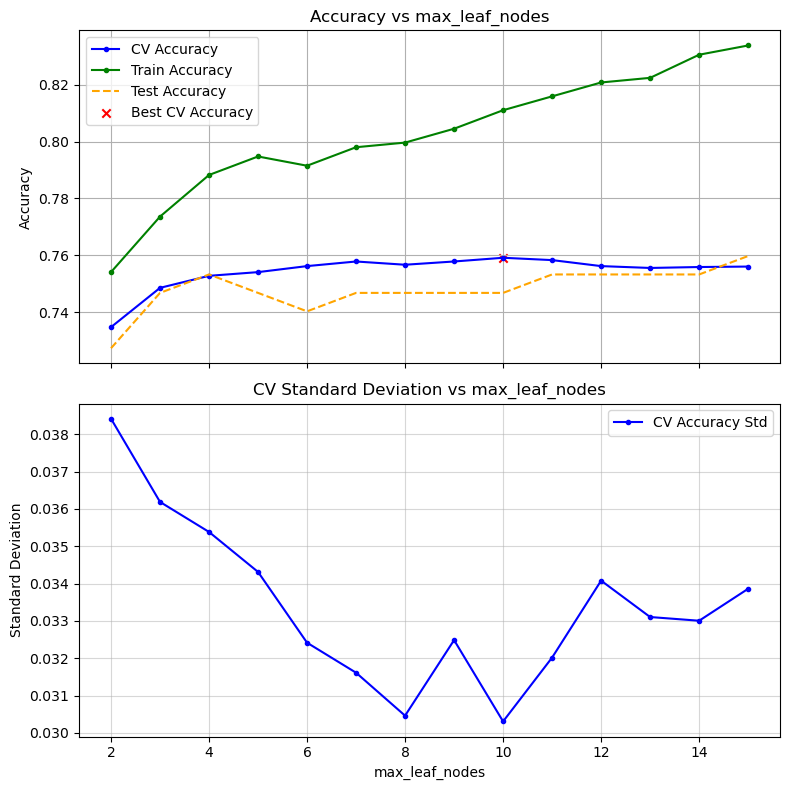

Execution Time: 00:00:07
{'n_estimators': 160, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'log2', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'bootstrap': True, 'oob_score': False, 'warm_start': False, 'class_weight': 'balanced', 'ccp_alpha': 0.0005, 'max_samples': None, 'monotonic_cst': None, 'accuracy_found': 0.7591216846594697, 'random_state': 42}


In [138]:
rf_default_params = sweep_parameter(
    model=RandomForestClassifier,
    Parameters=rf_default_params,
    param='max_leaf_nodes',
    parameter_list=[None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
)

print(rf_default_params)

Sweeping min_impurity_decrease: 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]


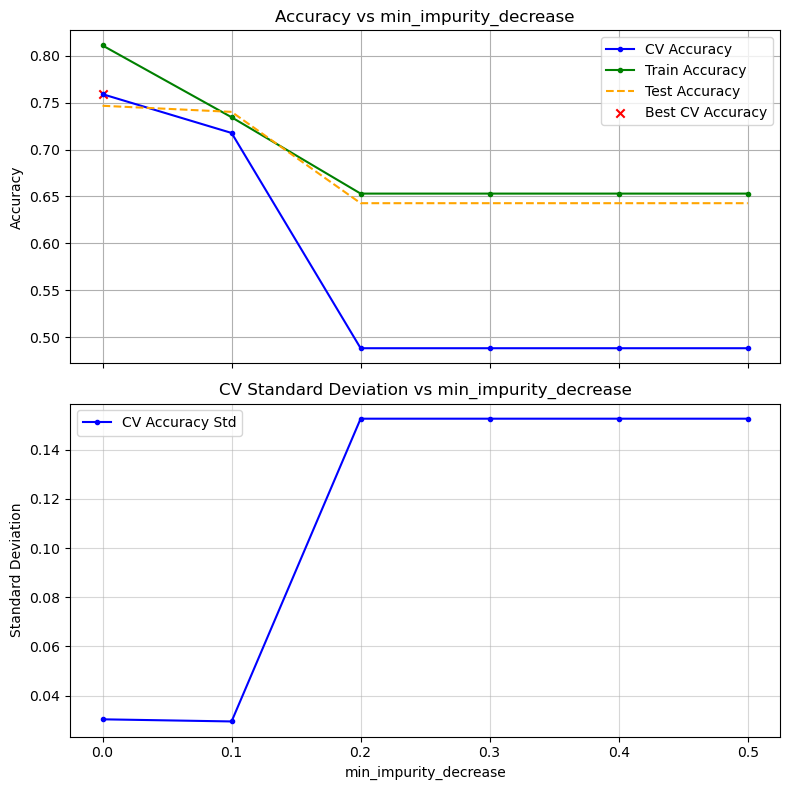

Execution Time: 00:00:02
{'n_estimators': 160, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'log2', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'bootstrap': True, 'oob_score': False, 'warm_start': False, 'class_weight': 'balanced', 'ccp_alpha': 0.0005, 'max_samples': None, 'monotonic_cst': None, 'accuracy_found': 0.7591216846594697, 'random_state': 42}


In [139]:
rf_default_params = sweep_parameter(
    model=RandomForestClassifier,
    Parameters=rf_default_params,
    param='min_impurity_decrease',
    parameter_list=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
)
print(rf_default_params)

Sweeping bootstrap: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


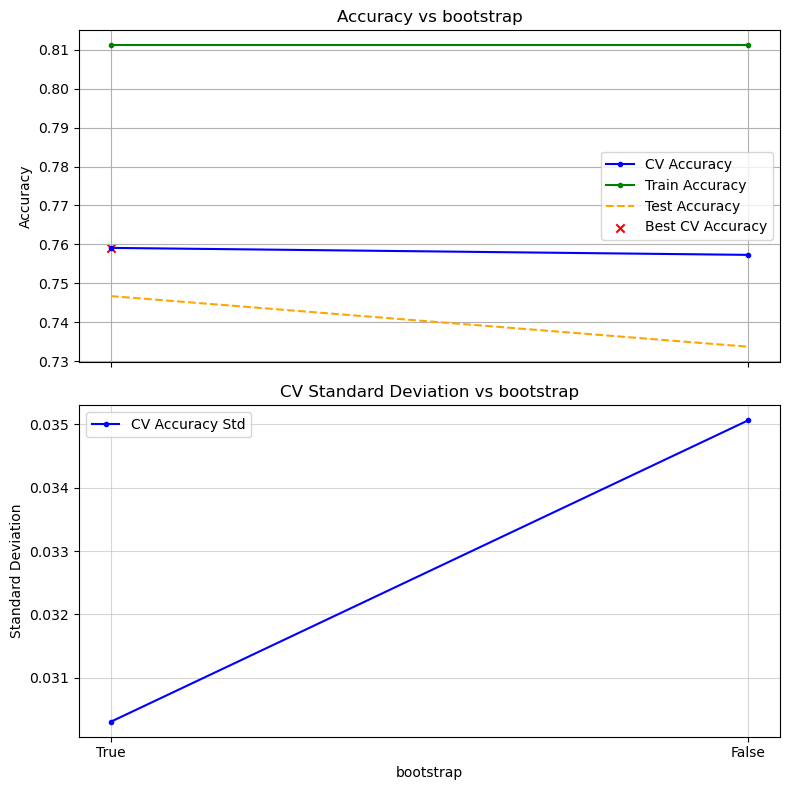

Execution Time: 00:00:01
{'n_estimators': 160, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'log2', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'bootstrap': True, 'oob_score': False, 'warm_start': False, 'class_weight': 'balanced', 'ccp_alpha': 0.0005, 'max_samples': None, 'monotonic_cst': None, 'accuracy_found': 0.7591216846594697, 'random_state': 42}


In [140]:
rf_default_params = sweep_parameter(
    model=RandomForestClassifier,
    Parameters=rf_default_params,
    param='bootstrap',
    parameter_list=[True, False]
)
print(rf_default_params)

Sweeping ccp_alpha: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


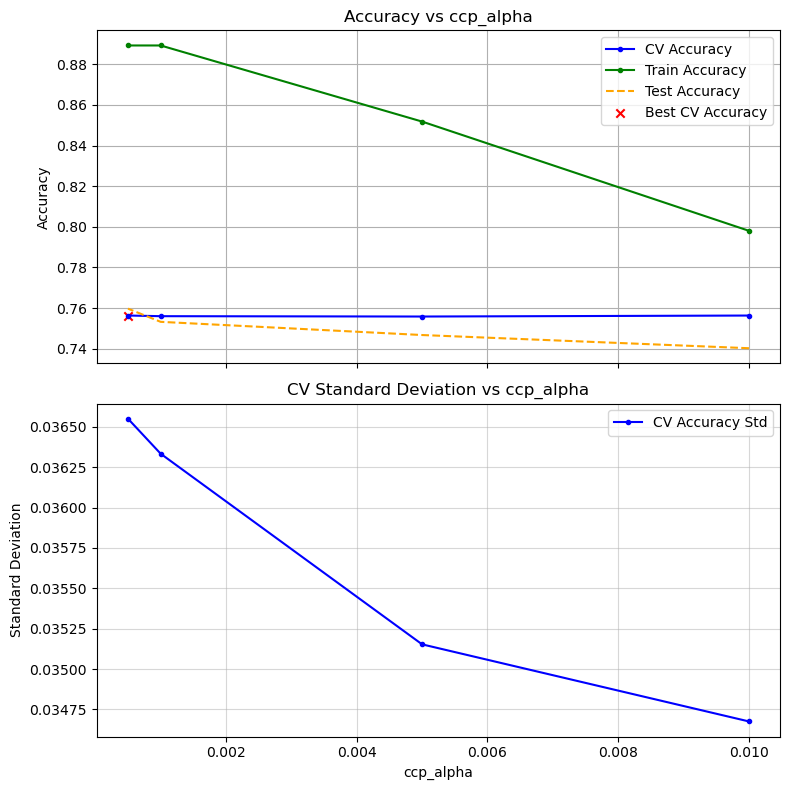

Execution Time: 00:00:02
{'n_estimators': 160, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'bootstrap': True, 'oob_score': False, 'warm_start': False, 'class_weight': 'balanced', 'ccp_alpha': 0.0005, 'max_samples': None, 'monotonic_cst': None, 'accuracy_found': 0.7563534586165533, 'random_state': 42}


In [125]:
rf_default_params = sweep_parameter(
    model=RandomForestClassifier,
    Parameters=rf_default_params,
    param='ccp_alpha',
    parameter_list=[0.01,0.005,0.001,0.0005]
)
print(rf_default_params)

/opt/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Random Forest Results:
Best Parameters: {'bootstrap': True, 'ccp_alpha': 0.001, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Cross-Validation Accuracy: 0.7916
Test Accuracy: 0.7532
              precision    recall  f1-score   support

           0     0.8211    0.7879    0.8041        99
           1     0.6441    0.6909    0.6667        55

    accuracy                         0.7532       154
   macro avg     0.7326    0.7394    0.7354       154
weighted avg     0.7578    0.7532    0.7550       154



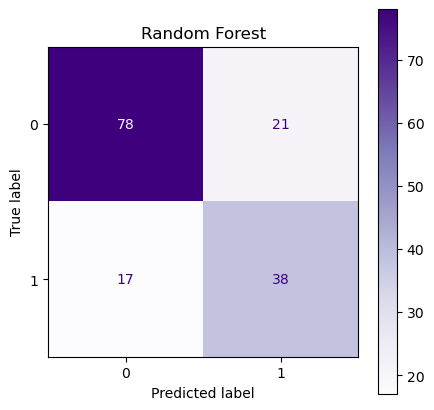

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Random Forest with GridSearchCV

# Adapted parameter grid with broader hyperparameter ranges
param_grid_rf = {
    'n_estimators': [100, 200, 300],      # Number of trees
    'max_depth': [None, 5, 10, 15],       # Tree depth
    'min_samples_split': [2, 5, 10],      # Min samples needed for an internal node split
    'min_samples_leaf': [1, 2, 5],        # Min samples needed to form a leaf
    'max_features': ['sqrt', 'log2', 0.5],# Feature subset size at each split
    'bootstrap': [True, False],           # Whether to bootstrap samples
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01] # Pruning parameter
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid_rf, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

# Best Random Forest model
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Print results
print("\nRandom Forest Results:")
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Cross-Validation Accuracy: {grid_rf.best_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf, digits=4))

# Confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap='Purples', ax=ax)
ax.set_title("Random Forest")
plt.show()

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits

Bagging Classifier Results:
Best Parameters: {'bootstrap': True, 'bootstrap_features': False, 'estimator__max_depth': 10, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50}
Cross-Validation Accuracy: 0.7948
Test Accuracy: 0.7662
              precision    recall  f1-score   support

           0     0.8247    0.8081    0.8163        99
           1     0.6667    0.6909    0.6786        55

    accuracy                         0.7662       154
   macro avg     0.7457    0.7495    0.7474       154
weighted avg     0.7683    0.7662    0.7671       154



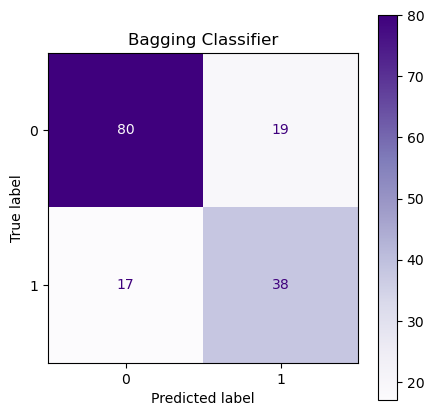

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Example Bagging Classifier with Decision Tree base estimator
bc = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),  # <-- Updated
    random_state=42
)

# Parameter grid
# Note the base estimator parameters are now prefixed with 'estimator__'
param_grid_bc = {
    'estimator__max_depth': [None, 5, 10],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 5],
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

# Set up the GridSearchCV
grid_bc = GridSearchCV(
    estimator=bc,
    param_grid=param_grid_bc,
    cv=5,            # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,       # Use all available CPU cores
    verbose=1        # Print progress
)

# Fit on the training data
grid_bc.fit(X_train, y_train)

# Extract the best estimator from the grid search
best_bc = grid_bc.best_estimator_
y_pred_bc = best_bc.predict(X_test)

# Print results
print("\nBagging Classifier Results:")
print(f"Best Parameters: {grid_bc.best_params_}")
print(f"Cross-Validation Accuracy: {grid_bc.best_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_bc):.4f}")
print(classification_report(y_test, y_pred_bc, digits=4))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_estimator(best_bc, X_test, y_test, cmap='Purples', ax=ax)
ax.set_title("Bagging Classifier")
plt.show()

### Problem 3.A Graded Answer

Provide the mean CV accuracy score of your best model in the next cell. 

In [33]:
# Insert the mean CV accuracy

a3a = 0.0                              # Just to get this cell to run without errors, put your answer here                 

print(f'a3a = {a3a:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a3a = 0.0000


### Problem 3.B Graded Answer

Provide the test accuracy of your best model in the next cell. 

In [34]:
# Insert the test accuracy

a3b = 0.0                              # Just to get this cell to run without errors, put your answer here 

print(f'a3b = {a3b:.4f}')              # Do not change this line, and DO NOT print anything else in this cell

a3b = 0.0000
